# Dog vs Cat Classification using SVM

In [4]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook
from sklearn import svm, metrics
from sklearn.utils import Bunch
from sklearn.model_selection import train_test_split
import time
from skimage.transform import resize
from skimage import io
import skimage
import cv2
from glob import glob
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import ConfusionMatrixDisplay

# Prepare

## Load

In [5]:
def load_image_files(container_path, dimension=(64, 64)):
    image_dir = glob(f'{container_path}/*', recursive=True)
    categories = ['dog', 'cat']
    descr = "A image classification dataset"
    images = []
    flat_data = []
    target = []
    for image in tqdm(image_dir):
            img = skimage.io.imread(image)
            img_resized = resize(img, dimension, anti_aliasing=True, mode='reflect')
            flat_data.append(img_resized.flatten()) 
            images.append(img_resized)
            if 'dog' in image:
                target.append(1)
            else:
                target.append(0)
    flat_data = np.array(flat_data)
    target = np.array(target)
    images = np.array(images)

    return Bunch(data=flat_data,
                 target=target,
                 target_names=categories,
                 images=images,
                 DESCR=descr)

In [8]:
start_time = time.time()
image_dataset = load_image_files("train")
end_time = time.time()
print(f"Total time taken to load the dataset is {(end_time - start_time):.5f} seconds")

100%|██████████| 25000/25000 [06:43<00:00, 61.99it/s]


Total time taken to load the dataset is 411.14143 seconds


## Explore and  preprocess

## Visualize

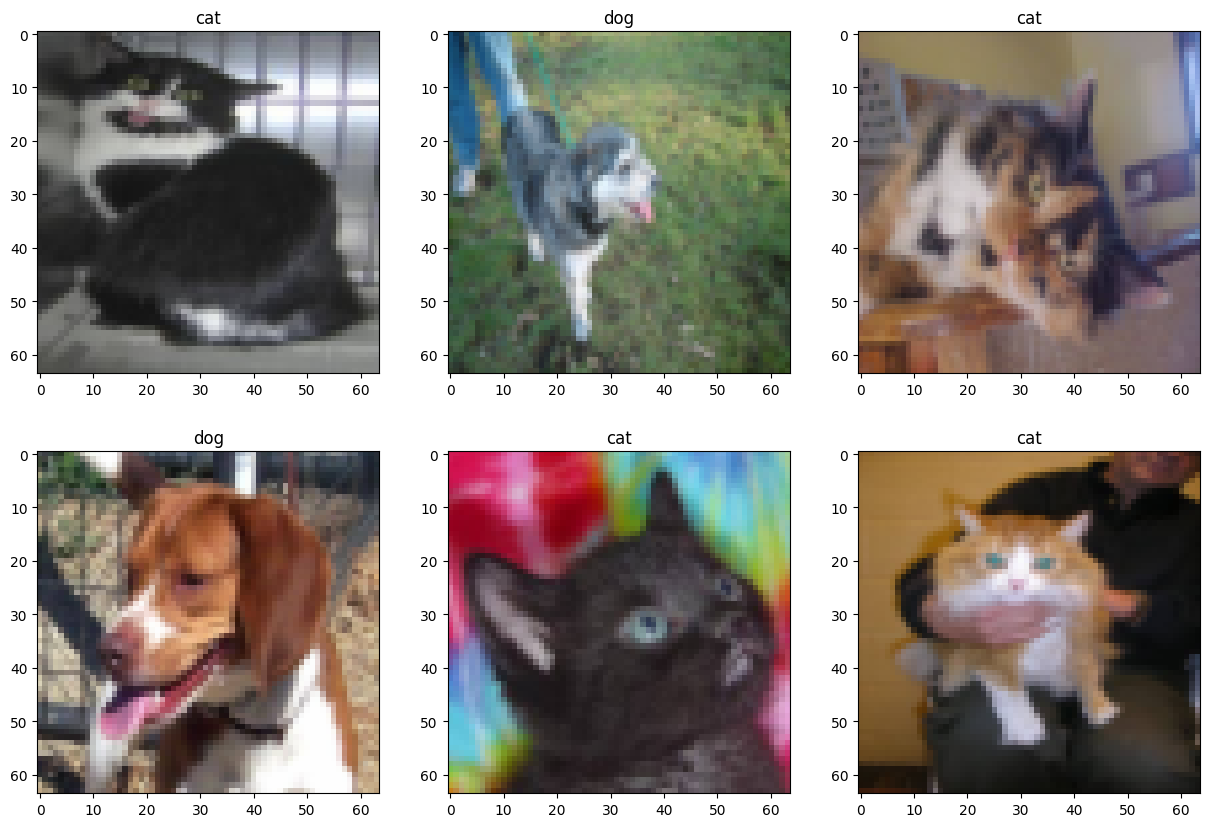

In [10]:
# load 5 images and plot them, make fige size bigger 3*2 and print dog if label is 1, else print cat
%matplotlib inline
fig, ax=plt.subplots(2,3, figsize=(15,10))
for i in range(6):
    ax[i//3, i%3].imshow(image_dataset.images[i])
    if image_dataset.target[i]==1:
        ax[i//3, i%3].set_title('dog')
    else:
        ax[i//3, i%3].set_title('cat')

## Split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    image_dataset.data, image_dataset.target, test_size=0.2,random_state=42)

In [12]:
%time
X_train.shape, X_test.shape, y_train.shape, y_test.shape

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


((20000, 12288), (5000, 12288), (20000,), (5000,))

# Train


In [13]:

model=svm.SVC() 


In [1]:
start_time = time.time()
model.fit(X_train, y_train)
end_time = time.time()
print(f"Total time taken to train the model is {(end_time - start_time):.5f} seconds")

[LibSVM]..............*....*
optimization finished, #iter = 18232
obj = -11709.329475, rho = 0.851154
nSV = 16499, nBSV = 12745
Total nSV = 16499
Total time taken to train the model is 3881.43218 seconds


In [2]:
start_time = time.time()
model.score(X_test, y_test)
end_time = time.time()
print(f"Total time taken to test the model is {(end_time - start_time):.5f} seconds")

Total time taken to test the model is 2175.20540 seconds


In [3]:
# print classification report
start_time = time.time()
y_pred = model.predict(X_test)
print(metrics.classification_report(y_test, y_pred))
end_time = time.time()
print(f"Total time taken to print the classification report is {(end_time - start_time):.5f} seconds")

              precision    recall  f1-score   support

           0       0.68      0.67      0.68      2478
           1       0.68      0.69      0.68      2522

    accuracy                           0.68      5000
   macro avg       0.68      0.68      0.68      5000
weighted avg       0.68      0.68      0.68      5000

Total time taken to print the classification report is 2211.34103 seconds


In [4]:
# print confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['cat', 'dog'])

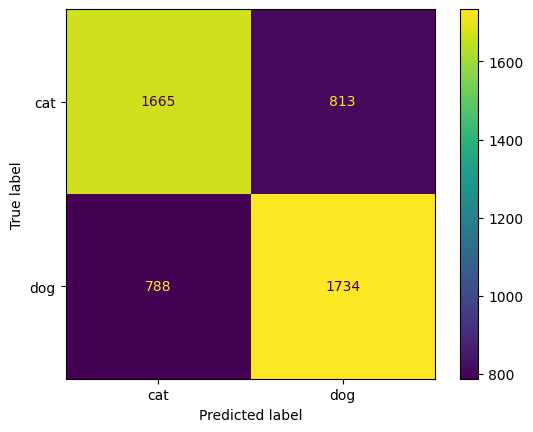

In [5]:
disp.plot()
plt.show()

In [7]:
# load test images
test_images = glob(f'test1/*', recursive=True)


In [8]:
test_images[0]

'test1/1997.jpg'

In [9]:
# rotate one image then predict
image = cv2.imread(test_images[3])
image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)

cat


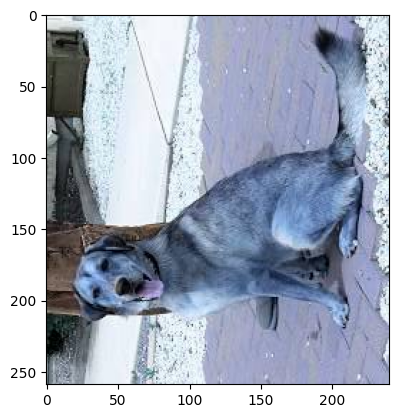

In [10]:
# predict the rotated image and print the result the and teh image  
%matplotlib inline
img = resize(image, (64, 64))
# predict the image and print dog if label is 1, else print cat
pred=model.predict(img.flatten().reshape(1,-1))
if pred==1:
    print('dog')
else:
    print('cat')
plt.imshow(image);

# Import pytorch assets


In [11]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np  
import pandas as pd
import seaborn as sns
import os
import time
import copy
from PIL import Image

In [12]:
# Read the train data,
train_dir = 'train'
test_dir = 'test1'
images=glob(os.path.join(train_dir,'*.jpg'))


In [13]:
# Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(10),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])
test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])


In [14]:
class CustomDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        image = Image.open(self.file_list[idx]).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = os.path.splitext(self.file_list[idx])[0].split('.')[0].split('/')[-1]
        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0

        return image, label

In [15]:
start_time = time.time()
train_files, val_files = train_test_split(images, test_size=0.2, random_state=42)
train_dataset = CustomDataset( train_files, transform=train_transforms)
val_dataset = CustomDataset( val_files, transform=test_transforms)
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
end_time = time.time()
print(f"Total time taken to load the dataset is {(end_time - start_time):.5f} seconds")

Total time taken to load the dataset is 0.01133 seconds


In [16]:
# load sample images
dataiter = next(iter(train_dataloader))


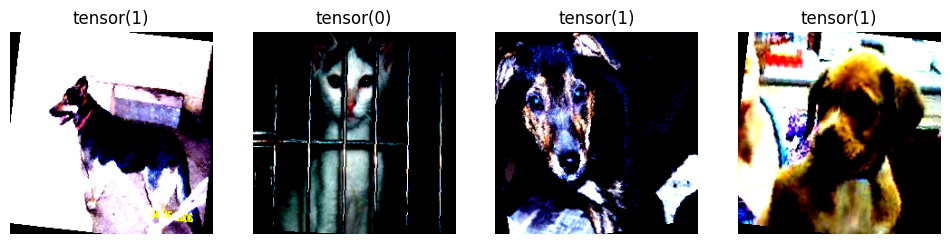

In [17]:
# show images
%matplotlib inline
fig, axes = plt.subplots(figsize=(12, 12), ncols=4)
for i in range(4):
    ax = axes[i]
    ax.imshow(dataiter[0][i].permute(1, 2, 0))
    ax.axis('off')
    ax.set_title(dataiter[1][i])

In [18]:
# load pretrained model
model = models.vgg16(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:01<00:00, 297MB/s]  


In [19]:
# freeze all model parameters
for param in model.parameters():
    param.requires_grad = False


In [20]:
# change the last layer
model.classifier[6] = nn.Linear(4096, 2)

In [21]:
# check if cuda is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# move model to GPU if cuda is available
model = model.to(device)

In [22]:
# define loss function
criterion = nn.CrossEntropyLoss()
# define optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# define learning rate scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [24]:
# train the model
num_epochs = 10
for epoch in range(num_epochs):
    exp_lr_scheduler.step()
    train_loss = 0.0
    train_acc = 0.0
    val_loss = 0.0
    val_acc = 0.0
    model.train()
    # use tqdm to show progress bar
    for i, (inputs, labels) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        ret, predictions = torch.max(outputs.data, 1)
        correct_counts = predictions.eq(labels.data.view_as(predictions))
        acc = torch.mean(correct_counts.type(torch.FloatTensor))
        train_acc += acc.item() * inputs.size(0)
        # print training loss and accuracy of each epoch
    train_loss = train_loss / len(train_dataloader.dataset)
    train_acc = train_acc / len(train_dataloader.dataset)
    print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.6f}'.format(
        epoch + 1, train_loss, train_acc))
    model.eval()
    # use tqdm to show progress bar
    for i, (inputs, labels) in tqdm(enumerate(val_dataloader), total=len(val_dataloader)):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item() * inputs.size(0)
        ret, predictions = torch.max(outputs.data, 1)
        correct_counts = predictions.eq(labels.data.view_as(predictions))
        acc = torch.mean(correct_counts.type(torch.FloatTensor))
        val_acc += acc.item() * inputs.size(0)
        # print validation loss and accuracy of each epoch
    val_loss = val_loss / len(val_dataloader.dataset)
    val_acc = val_acc / len(val_dataloader.dataset)
    print('Epoch: {} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(
        epoch + 1, val_loss, val_acc))

100%|██████████| 625/625 [02:06<00:00,  4.93it/s]


Epoch: 1 	Training Loss: 0.038661 	Training Accuracy: 0.986150


100%|██████████| 157/157 [00:29<00:00,  5.28it/s]


Epoch: 1 	Validation Loss: 0.030556 	Validation Accuracy: 0.987200


100%|██████████| 625/625 [02:06<00:00,  4.94it/s]


Epoch: 2 	Training Loss: 0.039623 	Training Accuracy: 0.984850


100%|██████████| 157/157 [00:29<00:00,  5.27it/s]


Epoch: 2 	Validation Loss: 0.030623 	Validation Accuracy: 0.987400


100%|██████████| 625/625 [02:06<00:00,  4.94it/s]


Epoch: 3 	Training Loss: 0.039750 	Training Accuracy: 0.985300


100%|██████████| 157/157 [00:29<00:00,  5.31it/s]


Epoch: 3 	Validation Loss: 0.030808 	Validation Accuracy: 0.987200


100%|██████████| 625/625 [02:06<00:00,  4.96it/s]


Epoch: 4 	Training Loss: 0.042036 	Training Accuracy: 0.984200


100%|██████████| 157/157 [00:29<00:00,  5.32it/s]


Epoch: 4 	Validation Loss: 0.030835 	Validation Accuracy: 0.987000


100%|██████████| 625/625 [02:06<00:00,  4.95it/s]


Epoch: 5 	Training Loss: 0.038423 	Training Accuracy: 0.986700


100%|██████████| 157/157 [00:29<00:00,  5.34it/s]


Epoch: 5 	Validation Loss: 0.030845 	Validation Accuracy: 0.987200


100%|██████████| 625/625 [02:07<00:00,  4.92it/s]


Epoch: 6 	Training Loss: 0.038059 	Training Accuracy: 0.985650


100%|██████████| 157/157 [00:29<00:00,  5.27it/s]


Epoch: 6 	Validation Loss: 0.030847 	Validation Accuracy: 0.987200


100%|██████████| 625/625 [02:06<00:00,  4.94it/s]


Epoch: 7 	Training Loss: 0.038785 	Training Accuracy: 0.984750


100%|██████████| 157/157 [00:29<00:00,  5.29it/s]


Epoch: 7 	Validation Loss: 0.030834 	Validation Accuracy: 0.987200


100%|██████████| 625/625 [02:07<00:00,  4.92it/s]


Epoch: 8 	Training Loss: 0.040387 	Training Accuracy: 0.984850


100%|██████████| 157/157 [00:29<00:00,  5.30it/s]


Epoch: 8 	Validation Loss: 0.030801 	Validation Accuracy: 0.987200


100%|██████████| 625/625 [02:06<00:00,  4.92it/s]


Epoch: 9 	Training Loss: 0.042287 	Training Accuracy: 0.984650


100%|██████████| 157/157 [00:29<00:00,  5.30it/s]


Epoch: 9 	Validation Loss: 0.030817 	Validation Accuracy: 0.987200


100%|██████████| 625/625 [02:07<00:00,  4.91it/s]


Epoch: 10 	Training Loss: 0.041499 	Training Accuracy: 0.984750


100%|██████████| 157/157 [00:29<00:00,  5.31it/s]

Epoch: 10 	Validation Loss: 0.030820 	Validation Accuracy: 0.987200


In [25]:
y_pred = []
y_true = []
model.eval()
for i, (inputs, labels) in tqdm(enumerate(val_dataloader), total=len(val_dataloader)):
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    y_pred.extend(preds.cpu().numpy())
    y_true.extend(labels.cpu().numpy())

100%|██████████| 157/157 [00:29<00:00,  5.23it/s]


In [26]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['cat', 'dog'])

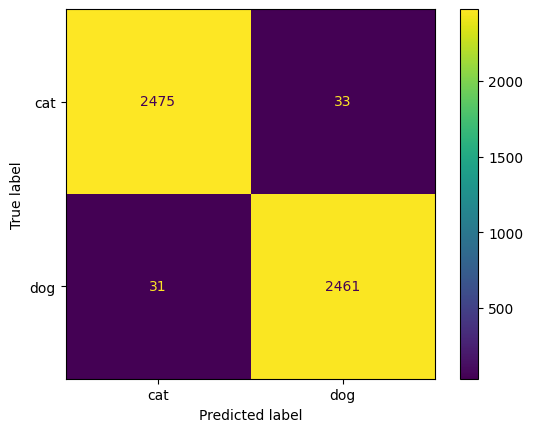

In [27]:
disp.plot()
plt.show()

We have come to conclusion, using skimge is slower than PIL, you can see that it takes about 40 minutes to train SVM and get accurcy about 68%. In contrast, when I used pre-trained model it takes only about 20 minutes to get 98% on validation set.

so in my opinion:\
1- Using skimage is not a good idea\
2- Using SVM on image data is a waste of time\
3- CNN is better suited for unstructured data like image